# Import package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 175)

# Import data

In [2]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [3]:
original_df = df.copy()

In [4]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [5]:
df.shape

(768, 9)

# Data Preprocessing

In [6]:
df = df.fillna(df.mean())
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
numdf = df[num_vars].drop(['Outcome'],axis=1)

from sklearn.preprocessing import MinMaxScaler
numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns

In [8]:
X = numdf_norm
print (X.shape)
y = df['Outcome']
print (y.shape)

(768, 8)
(768,)


## Spliting data into training and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
X_train.shape, X_test.shape

((614, 8), (154, 8))

# Train and perform cross validation

In [10]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 5, metric ='minkowski', p=2)


kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
scores

array([0.75806452, 0.75806452, 0.72580645, 0.67741935, 0.73770492,
       0.67213115, 0.73770492, 0.75409836, 0.72131148, 0.72131148])

In [11]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 72.64% (+/- 5.80%)


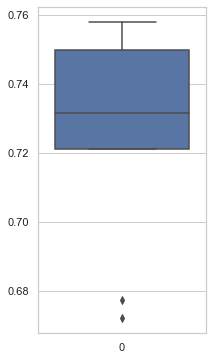

In [12]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

# Prediction

In [13]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

# Model Evaluation

### Accuracy

In [14]:
accuracy_score(y_train, y_train_pred)

0.8143322475570033

In [15]:
accuracy_score(y_test, y_test_pred)

0.7402597402597403

### Confusion matrix

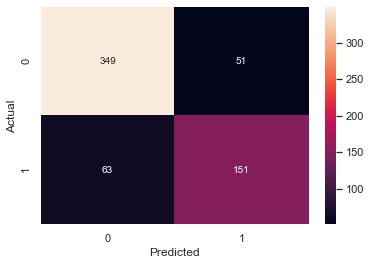

In [18]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [20]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       400
           1       0.75      0.71      0.73       214

    accuracy                           0.81       614
   macro avg       0.80      0.79      0.79       614
weighted avg       0.81      0.81      0.81       614



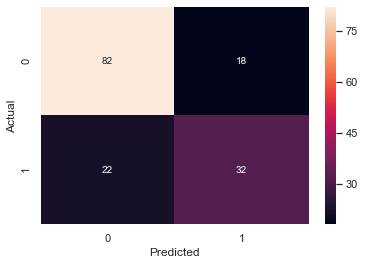

In [21]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

### Classification Report

In [22]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.64      0.59      0.62        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



### ROC AUC Score

In [23]:
roc_auc_score(y_train, prob_train_pred[:,1])

0.8981658878504672

In [24]:
roc_auc_score(y_test,  prob_test_pred[:,1])

0.7999074074074074

### ROC Curve

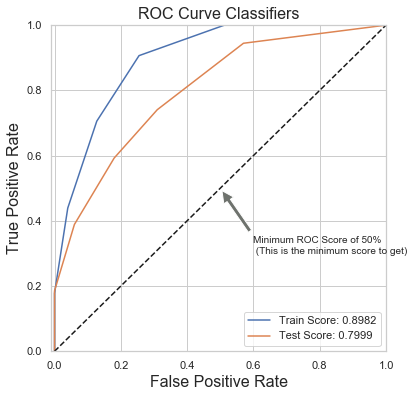

In [25]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

### Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.67')

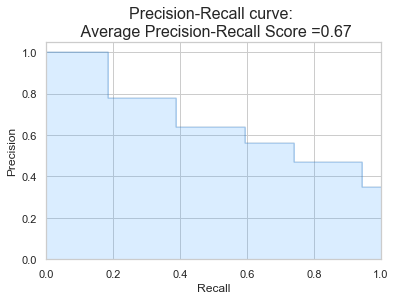

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

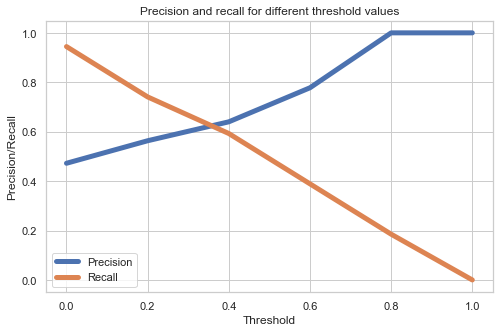

In [27]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.78')

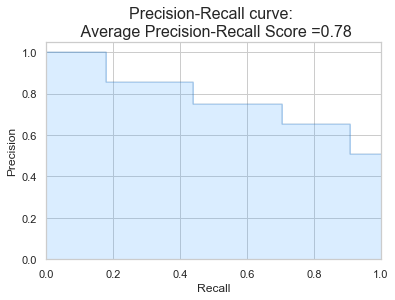

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

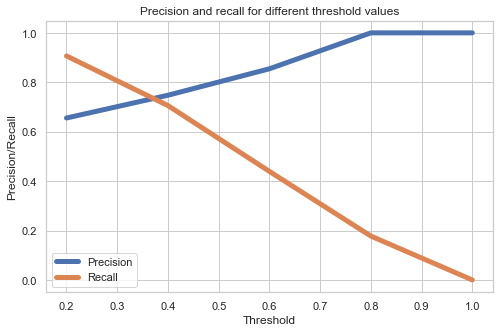

In [29]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Summary

In [30]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    

In [31]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'KNN')

Model Evaluation of KNN
-----------------------------------------------------------
Train set
Accuracy:  0.8143322475570033
ROC AUC Score:  0.8981658878504672
Confusion matrix
True         0    1
Predicted          
0          349   51
1           63  151
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       400
           1       0.75      0.71      0.73       214

    accuracy                           0.81       614
   macro avg       0.80      0.79      0.79       614
weighted avg       0.81      0.81      0.81       614

-----------------------------------------------------------
Test set
Accuracy:  0.7402597402597403
ROC AUC Score:  0.7999074074074074
Confusion matrix
True        0   1
Predicted        
0          82  18
1          22  32
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.64      0.59      0.62        54

    accuracy                  

# Tuning hyper-parameters

In [32]:
params = {"n_neighbors": list(range(2,8,1)), 'algorithm':['auto','ball_tree','kd_tree','brute']}
grid_search = GridSearchCV(KNeighborsClassifier(), params)
grid_search.fit(X_train, y_train)

# KNears best estimator
best_model = grid_search.best_estimator_
best_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [33]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 75.25% (+/- 5.94%)


In [34]:
scores

array([0.75806452, 0.77419355, 0.70967742, 0.75806452, 0.70491803,
       0.73770492, 0.80327869, 0.73770492, 0.78688525, 0.75409836])

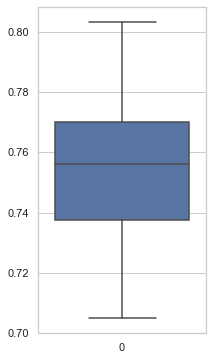

In [35]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

In [36]:
model = best_model

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

In [37]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'KNN')

Model Evaluation of KNN
-----------------------------------------------------------
Train set
Accuracy:  0.8110749185667753
ROC AUC Score:  0.8818808411214953
Confusion matrix
True         0    1
Predicted          
0          347   53
1           63  151
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       400
           1       0.74      0.71      0.72       214

    accuracy                           0.81       614
   macro avg       0.79      0.79      0.79       614
weighted avg       0.81      0.81      0.81       614

-----------------------------------------------------------
Test set
Accuracy:  0.7662337662337663
ROC AUC Score:  0.8069444444444445
Confusion matrix
True        0   1
Predicted        
0          85  15
1          21  33
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       100
           1       0.69      0.61      0.65        54

    accuracy                  

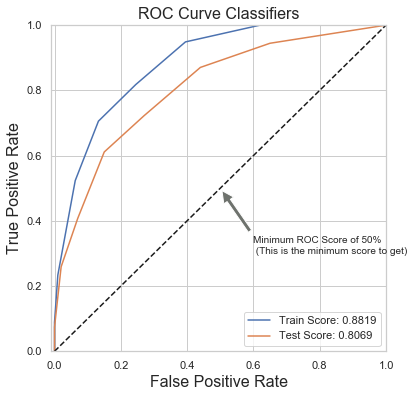

In [38]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()